<a href="https://colab.research.google.com/github/kibutan/signate/blob/main/Signate_%E8%87%AA%E5%8B%95%E8%BB%8A%E3%81%AE%E8%B5%B0%E8%A1%8C%E8%B7%9D%E9%9B%A2%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install signate

     |████████████████████████████████| 133kB 6.4MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=96ae8d0fa0c8bd575c1cfe9f334a9e9a1f76906488f86955f15e6db5c73e912d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
#kaggle.jsonをGoogle Drive からひっぱってくるやつ
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!signate list

  competitionId  title                                                              closing     prize                             submitters
---------------  -----------------------------------------------------------------  ----------  ------------------------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                               -                                                   4201
             24  【練習問題】お弁当の需要予測                                       -                                                   4987
             27  【練習問題】Jリーグの観客動員数予測                                -                                                   1055
            100  【練習問題】手書き文字認識                                         -           Knowledge                                104
            102  【練習問題】タイタニックの生存予測                                 -           Knowledge                                406
            103  【練習問題】音楽ラベリング                                         -           Knowledge

In [3]:
#規約同意前ならエラーを返す。yを入力後再実行でダウンロードが可能に。
#指定しない限り、カレントディレクトリにデータは降りる。
!signate download -c 121

sample_submit.csv

test.tsv

train.tsv


Download completed.


In [ ]:
!ls

adc.json  sample_data  sample_submit.csv  test.tsv  train.tsv


流れ
1. 自動車データの読み込み・確認
  * データ読み込み
  * データ精査
  * 欠損値・異常値の確認
2. 自動車データの特徴把握
  * 変数の分布・値の確認
  * 変数間の相関
3. 燃費予測モデルの作成
  * 学習・評価データの分割
  * 評価関数の定義
  * モデルの学習
  * モデルの精度評価
4. 燃費予測モデルの予測精度改善
  * ダミー変数化
  * 対数化




In [38]:
import pandas as pd
import matplotlib.pyplot as plt
# train = pd.read_csv("train.tsv",sep="\t",
#                     dtype={"id":"int","mpg":"float","cylinders":"object", 
#                            "displacement":"float", "horsepower":"float",
#                            "acceleration":"float","model year":"object",
#                            "origin":"object", "car name":"object"})
train = pd.read_csv("train.tsv",sep="\t",na_values="?")
test = pd.read_csv("test.tsv",sep="\t",na_values="?")
submit = pd.read_csv("sample_submit.csv", header=None, names=['id', 'mpg'])

ハマりポイント
isnull().sum()で数値データがObjectになる場合、?　や - など、NaNと認識されない文字が入力されているかもしれない。
そんなときは読み込み時、read_csvにオプションna_valuesで欠損値を新たに指定してやるといい。



In [39]:
train.isnull().sum()

id              0
mpg             0
cylinders       0
displacement    0
horsepower      4
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [46]:
train_dropna = train.dropna()
train_dropna["horsepower"] = train_dropna["horsepower"].astype("float")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
train_dropna["horsepower"].shape

(195,)

In [55]:
train_dropna["horsepower"].describe()

count    195.000000
mean     101.297436
std       35.562255
min       46.000000
25%       75.000000
50%       92.000000
75%      114.000000
max      220.000000
Name: horsepower, dtype: float64

(array([16., 46., 51., 34., 10., 20.,  6.,  6.,  4.,  2.]),
 array([ 46. ,  63.4,  80.8,  98.2, 115.6, 133. , 150.4, 167.8, 185.2,
        202.6, 220. ]),
 <a list of 10 Patch objects>)

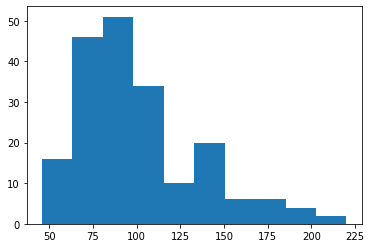

In [60]:
plt.hist(train_dropna["horsepower"])

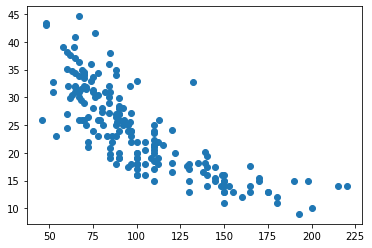

In [53]:
plt.scatter(train_dropna["horsepower"],train_dropna["mpg"])

In [18]:
test.dtypes

id                int64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [15]:
train.dtypes

id                int64
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [ ]:
train.head()

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,29.0,4,135.0,84.00,2525.0,16.0,82,1,dodge aries se
1,3,31.9,4,89.0,71.00,1925.0,14.0,79,2,vw rabbit custom
2,9,19.0,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii
3,11,28.0,4,90.0,75.00,2125.0,14.5,74,1,dodge colt
4,13,37.7,4,89.0,62.00,2050.0,17.3,81,3,toyota tercel


# データの精査

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE



In [ ]:
data = pd.concat([train,test],sort = False)

In [ ]:
data.isnull().sum()

id                0
mpg             199
cylinders         0
displacement      0
horsepower        0
weight            0
acceleration      0
model year        0
origin            0
car name          0
dtype: int64

In [ ]:
train = data[:len(train)]
test = data[len(train):]

In [ ]:
train.dtypes

id                int64
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [ ]:
train["horsepower"] = train["horsepower"].replace('"', '')


In [ ]:
#何故か馬力がStrなのでFloatに変換したい

train_float = train.astype({'horsepower': int})

ValueError: ignored

In [ ]:
y = train["mpg"]
X = train[['cylinders', 'displacement', 'horsepower', 'acceleration','model year', 'origin']]
X_test = test[['cylinders', 'displacement', 'horsepower', 'acceleration','model year', 'origin']]
train_dum = pd.get_dummies(X)
test_dum = pd.get_dummies(X_test)

In [ ]:
train_dum.head()

TypeError: ignored

In [ ]:
test_dum.head()

,cylinders,displacement,acceleration,model year,origin,horsepower_100.0,horsepower_102.0,horsepower_103.0,horsepower_105.0,horsepower_107.0,horsepower_110.0,horsepower_115.0,horsepower_116.0,horsepower_120.0,horsepower_125.0,horsepower_129.0,horsepower_130.0,horsepower_133.0,horsepower_137.0,horsepower_140.0,horsepower_142.0,horsepower_145.0,horsepower_150.0,horsepower_152.0,horsepower_153.0,horsepower_155.0,horsepower_158.0,horsepower_160.0,horsepower_165.0,horsepower_167.0,horsepower_170.0,horsepower_175.0,horsepower_180.0,horsepower_190.0,horsepower_198.0,horsepower_208.0,horsepower_210.0,horsepower_215.0,horsepower_225.0,horsepower_230.0,horsepower_46.00,horsepower_48.00,horsepower_49.00,horsepower_52.00,horsepower_53.00,horsepower_58.00,horsepower_60.00,horsepower_63.00,horsepower_65.00,horsepower_66.00,horsepower_67.00,horsepower_68.00,horsepower_69.00,horsepower_70.00,horsepower_71.00,horsepower_72.00,horsepower_74.00,horsepower_75.00,horsepower_76.00,horsepower_77.00,horsepower_78.00,horsepower_79.00,horsepower_80.00,horsepower_81.00,horsepower_83.00,horsepower_84.00,horsepower_85.00,horsepower_86.00,horsepower_87.00,horsepower_88.00,horsepower_90.00,horsepower_91.00,horsepower_92.00,horsepower_94.00,horsepower_95.00,horsepower_97.00,horsepower_98.00,horsepower_?
0,6,145.0,19.6,81,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,250.0,19.0,77,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4,119.0,15.0,80,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,6,258.0,13.5,71,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,97.0,16.5,72,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
